In [3]:
#!/usr/bin/env python
"""
MRI Transform Visualizer

This script visualizes the effects of transforms defined in the config file on MRI images.
It allows you to examine how each transform in the pipeline affects the images.
"""

import os
import yaml
import glob
import logging
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch
import torchio as tio
import argparse
from typing import Dict, List, Any, Optional, Tuple
import pydicom
import sys
from pathlib import Path

In [4]:
from minidl.transforms import build_transform_pipeline


def load_dicom_directory(dicom_dir: str) -> np.ndarray:
    """
    Load all DICOM files from a directory and return as a 3D numpy array.
    """
    dicom_files = sorted(glob.glob(os.path.join(dicom_dir, "*.dcm")))
    if not dicom_files:
        raise FileNotFoundError(f"No DICOM files found in {dicom_dir}")
    
    # Load the first file to get dimensions
    first_slice = pydicom.dcmread(dicom_files[0])
    
    # Initialize empty volume
    volume = np.zeros((len(dicom_files), *first_slice.pixel_array.shape), dtype=np.float32)
    
    # Load each slice
    for i, file_path in enumerate(dicom_files):
        try:
            ds = pydicom.dcmread(file_path)
            volume[i] = ds.pixel_array.astype(np.float32)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    
    return volume


def load_patient_data(data_dir: str, patient_index: int) -> Dict[str, np.ndarray]:
    """
    Load MRI data for a specific patient from the dataset.
    
    Returns a dictionary mapping phase names to volumes.
    """
    # Find the patient directory
    patient_dir_pattern = os.path.join(data_dir, f"Breast_MRI_{patient_index:03d}", "*")
    patient_dirs = glob.glob(patient_dir_pattern)
    
    if not patient_dirs:
        raise FileNotFoundError(f"Patient directory not found for index {patient_index}")
    
    patient_dir = patient_dirs[0]
    print(f"Loading data from {patient_dir}")
    
    # Find dynamic sequence directories
    sequences = {}
    required_phases = ["Ph1", "Ph2", "Ph3"]
    
    for subdir in os.listdir(patient_dir):
        dir_path = os.path.join(patient_dir, subdir)
        if not os.path.isdir(dir_path):
            continue
        
        # Check if it's a dynamic sequence
        if not (("dyn" in subdir.lower()) or ("vibrant" in subdir.lower())):
            continue
        
        # Identify phase
        phase = None
        if ("ph1" in subdir.lower()) or ("1st" in subdir.lower()):
            phase = "Ph1"
        elif ("ph2" in subdir.lower()) or ("2nd" in subdir.lower()):
            phase = "Ph2"
        elif ("ph3" in subdir.lower()) or ("3rd" in subdir.lower()):
            phase = "Ph3"
        
        if phase in required_phases:
            sequences[phase] = dir_path
    
    # Check if all required phases are found
    missing_phases = set(required_phases) - set(sequences.keys())
    if missing_phases:
        raise ValueError(f"Missing required phases: {missing_phases}")
    
    # Load DICOM files for each phase
    volumes = {}
    for phase, dir_path in sequences.items():
        volumes[phase] = load_dicom_directory(dir_path)
    
    return volumes


def visualize_slice(ax, volume, slice_idx, title=None, cmap='gray'):
    """Display a specific slice from a volume"""
    if volume.ndim == 3:  # [D, H, W]
        ax.imshow(volume[slice_idx], cmap=cmap)
    elif volume.ndim == 4:  # [C, D, H, W]
        ax.imshow(volume[0, slice_idx], cmap=cmap)
    else:
        raise ValueError(f"Unexpected volume shape: {volume.shape}")
    
    if title:
        ax.set_title(title)
    ax.axis('off')


def visualize_transforms(volumes: Dict[str, np.ndarray], transforms_config: List[Dict[str, Any]]):
    """
    Visualize how the transforms affect the volumes.
    """
    # Create a dictionary with the format expected by the transform pipeline
    original_data = {"images": [volumes[phase] for phase in ['Ph1', 'Ph2', 'Ph3']]}
    
    # Build and apply the transform pipeline
    transform_pipeline = build_transform_pipeline(transforms_config)
    transformed_data = transform_pipeline(original_data.copy())
    
    transformed_volumes = transformed_data['images']
    if not isinstance(transformed_volumes, list):
        transformed_volumes = [transformed_volumes]
    
    # Select slice indices to visualize (middle slice of each dimension)
    slice_indices = {}
    for phase, volume in volumes.items():
        slice_indices[phase] = volume.shape[0] // 2
    
    # Create a figure to display original and transformed images
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 3, figure=fig)
    
    # Plot original volumes
    for i, phase in enumerate(['Ph1', 'Ph2', 'Ph3']):
        ax = fig.add_subplot(gs[0, i])
        visualize_slice(ax, volumes[phase], slice_indices[phase], f"Original {phase}")
    
    # Plot transformed volumes
    for i, (volume, phase) in enumerate(zip(transformed_volumes, ['Ph1', 'Ph2', 'Ph3'])):
        ax = fig.add_subplot(gs[1, i])
        # Adjust slice index if dimensions changed
        if isinstance(volume, np.ndarray):
            if volume.ndim == 3:  # [D, H, W]
                transformed_slice_idx = min(slice_indices[phase], volume.shape[0] - 1)
            else:  # [C, D, H, W]
                transformed_slice_idx = min(slice_indices[phase], volume.shape[1] - 1)
        else:  # torch.Tensor
            if volume.ndim == 3:  # [D, H, W]
                transformed_slice_idx = min(slice_indices[phase], volume.size(0) - 1)
            else:  # [C, D, H, W]
                transformed_slice_idx = min(slice_indices[phase], volume.size(1) - 1)
        
        visualize_slice(ax, volume, transformed_slice_idx, f"Transformed {phase}")
    
    plt.tight_layout()
    
    # Create detailed figure showing individual transform effects
    if len(transforms_config) > 1:
        visualize_transform_sequence(original_data, transforms_config)


def visualize_transform_sequence(original_data: Dict[str, Any], transforms_config: List[Dict[str, Any]]):
    """
    Visualize the effect of each transform in the sequence.
    """
    # Take the first image (Ph1) for simplicity
    phase = 'Ph1'
    original_volume = original_data['images'][0]
    slice_idx = original_volume.shape[0] // 2
    
    # Create a figure to show the progression of transforms
    n_transforms = len(transforms_config) + 1  # +1 for original
    fig, axes = plt.subplots(1, n_transforms, figsize=(n_transforms * 5, 5))
    
    # Show original image
    visualize_slice(axes[0], original_volume, slice_idx, "Original")
    
    # Apply transforms one by one and show intermediate results
    current_data = original_data.copy()
    for i, transform_config in enumerate(transforms_config):
        # Create and apply individual transform
        transform = build_transform_pipeline([transform_config])
        current_data = transform(current_data.copy())
        
        # Get the first image (corresponding to Ph1)
        current_volume = current_data['images'][0] if isinstance(current_data['images'], list) else current_data['images']
        
        # Adjust slice index if dimensions changed
        if isinstance(current_volume, np.ndarray):
            if current_volume.ndim == 3:  # [D, H, W]
                current_slice_idx = min(slice_idx, current_volume.shape[0] - 1)
            else:  # [C, D, H, W]
                current_slice_idx = min(slice_idx, current_volume.shape[1] - 1)
        else:  # torch.Tensor
            if current_volume.ndim == 3:  # [D, H, W]
                current_slice_idx = min(slice_idx, current_volume.size(0) - 1)
            else:  # [C, D, H, W]
                current_slice_idx = min(slice_idx, current_volume.size(1) - 1)
        
        # Show transformed image
        transform_name = transform_config['name']
        visualize_slice(axes[i+1], current_volume, current_slice_idx, transform_name)
    
    plt.tight_layout()
    plt.show()

    

Loading data from ../data/Duke-Breast-Cancer-MRI/Breast_MRI_358/01-01-1990-NA-MRI BREAST BILATERAL WWO-31295


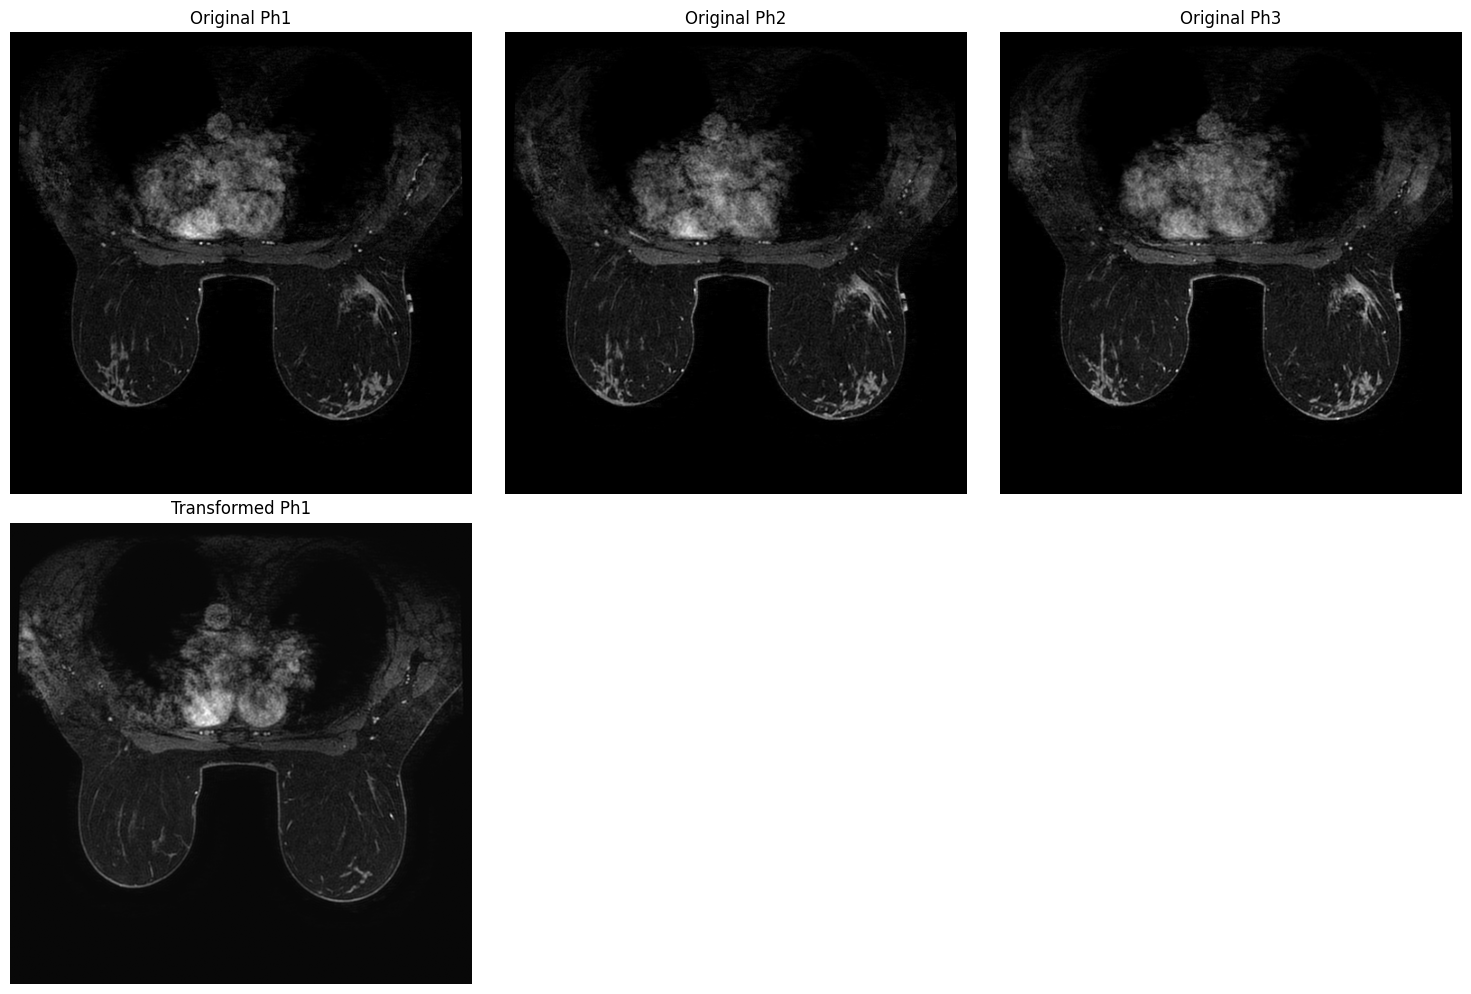

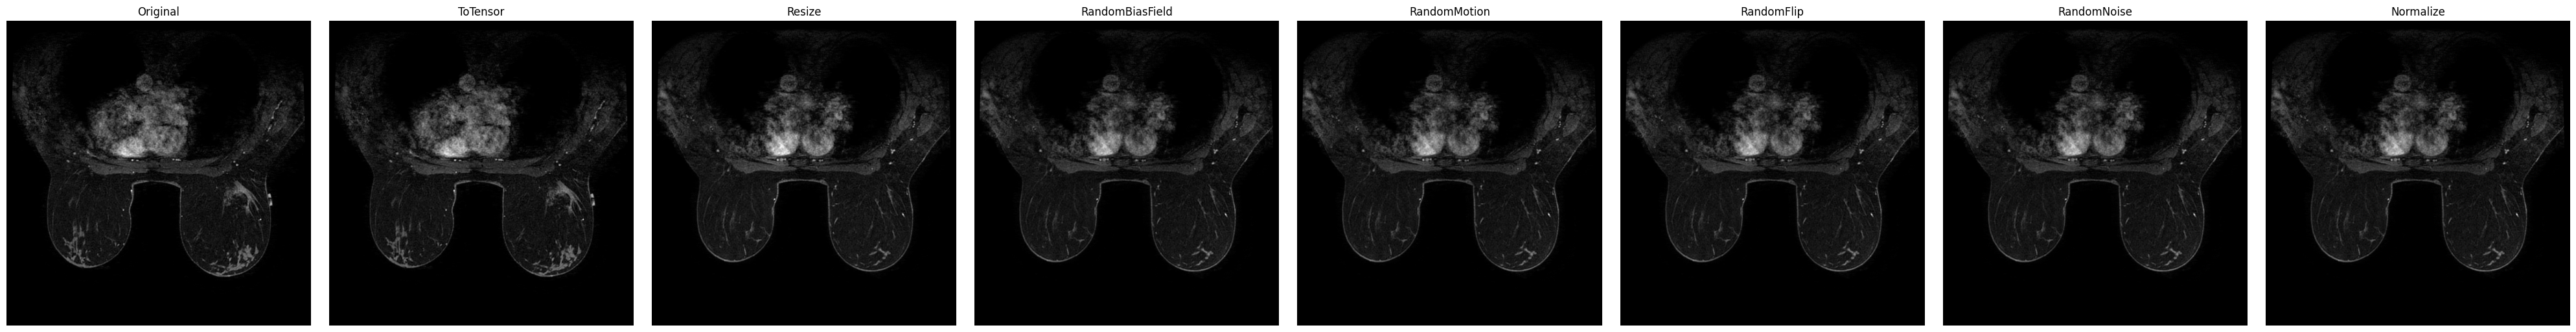

In [ ]:
args = {
    "config":"../configs/mri_pre_train/dataset.yaml",
    "patient": 358,
    "data_dir": "../data/Duke-Breast-Cancer-MRI",
    "split": "train"
}

# Load config file
try:
    with open(args["config"], 'r') as f:
        config = yaml.safe_load(f)
except Exception as e:
    print(f"Error loading config file: {e}")

# Extract transforms configuration for the specified split
transforms_config = config.get('dataset', {}).get('transforms', {}).get(args["split"], [])

volumes = load_patient_data(args["data_dir"], args["patient"])


# Visualize transforms
visualize_transforms(volumes, transforms_config)

plt.show()
